In [1]:
import sys
sys.path.insert(0,'../src/')

from utils import *
from multiply_connected_pipe import *
from pipe_system import PipeSystem
from abstract_pipe import *
from multiply_connected_pipe import MultiplyConnectedPipeFromPipeSystem

from matplotlib import pyplot as plt
import numpy as np
import pickle

In [2]:
with open('../exp1/pipes_and_shifts.pickle','rb') as f:
    pipes, shifts = pickle.load(f)

bdr_pipe = BoundaryPipe([BoundaryLet(-5,0,0,1,-1),BoundaryLet(31,0,np.pi,1,1)])
real_pipes = [RealPipe(p,shift_x=shift[0],shift_y=shift[1]) for p,shift in zip(pipes,shifts)]

In [3]:
ps = PipeSystem(real_pipes,bdr_pipe)

In [4]:
global_pipe = MultiplyConnectedPipeFromPipeSystem(ps)

In [10]:
global_pipe.build()

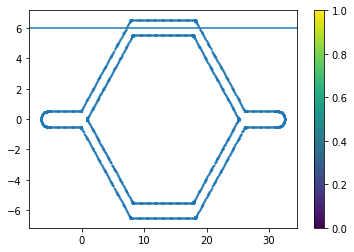

In [11]:
plt.scatter(global_pipe.t.real , global_pipe.t.imag,s=1)
plt.colorbar()
plt.axhline(6)

In [14]:
x = np.array([-3,15])
y = np.array([0,6])
global_pipe.velocity(x,y, omega=global_pipe.omegas[0])

IndexError: invalid index to scalar variable.